In [5]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

In [16]:
"""
unit defs
"""
ms = 0.001
mV = 0.001

In [186]:
"""
helper funcs
"""

### lowpass filter func
def lp(_in, _sp, _par=0.95):
    return _par * _in + (1 - _par) * _sp

from numpy.random import permutation
from scipy import rand, randn, ones
from scipy.sparse import csr_matrix

def _rand_sparse(m, n, density):
    # check parameters here
    if density > 1.0 or density < 0.0:
        raise ValueError('density should be between 0 and 1')
    # More checks?
    # Here I use the algorithm suggested by David to avoid ending
    # up with less than m*n*density nonzero elements (with the algorithm
    # provided by Nathan there is a nonzero probability of having duplicate
    # rwo/col pairs).
    nnz = max( min( int(m*n*density), m*n), 0)
    rand_seq = permutation(m*n)[:nnz]
    row  = rand_seq / n
    col  = rand_seq % n
    data = ones(nnz, dtype='int8')
    # duplicate (i,j) entries will be summed together
    return csr_matrix( (data,(row,col)), shape=(m,n) )

def sprand(m, n, density):
    """Build a sparse uniformly distributed random matrix
       Parameters
       ----------
       m, n     : dimensions of the result (rows, columns)
       density  : fraction of nonzero entries.
       Example
       -------
       >>> from scipy.sparse import sprand
       >>> print sprand(2, 3, 0.5).todense()
       matrix[[ 0.5724829   0.          0.92891214]
             [ 0.          0.07712993  0.        ]]
    """
    A = _rand_sparse(m, n, density)
    A.data = rand(A.nnz)
    return A

def sprandn(m, n, density, mu=0.0, var=1.0):
    """Build a sparse normally distributed random matrix
       Parameters
       ----------
       m, n     : dimensions of the result (rows, columns)
       density  : fraction of nonzero entries.
       Example
       -------
       >>> from scipy.sparse import sprandn
       >>> print sprandn(2, 4, 0.5).todense()
       matrix([[-0.84041995,  0.        ,  0.        , -0.22398594],
               [-0.664707  ,  0.        ,  0.        , -0.06084135]])
    """
    A = _rand_sparse(m, n, density)
    A.data = var*randn(A.nnz) + mu
    return A

#M = sprandn(100, 100, 0.1, mu=3.0, var=1.0)

In [435]:
class LIFnet():
    def __init__(self, _N=100):
        
        ##constants
        self.tau = 10 * ms   # membrane time constant
        self.R = 1           # membrane resistance
        self.Vr = -65 * mV   # resting potential
        self.Th = -35 * mV   # threshold potential to spike
        self.eps = 0.9999    # psp time constant
        self.g = 10.0         # weight gain
        self.N = _N
        
        ##containers
        self.V = self.Vr * np.ones(_N)
        self.I = np.zeros(_N)
        self.psp = np.zeros(_N)
        self.spk = np.zeros(_N)
        
        ## connectivity
        wsc = self.g/_N
        self.W = wsc*randn(_N, _N) - 10.*wsc*np.eye(_N) ##
        #self.W = sprandn(_N, _N, 0.01, mu=0.0, var=wsc) - 10.*wsc*np.eye(_N)
        #for i in range(_N):
        #   self.W(i,i) = 0.0
        
    
    def __len__(self):
        return self.N
    
    def run(self, _inputs, _timed):
        dt = _timed[1]
        spM = []
        vM = np.zeros((self.N, len(_timed)+1))
        vM[:,0] = self.V
        iM = np.zeros((self.N, len(_timed)+1))
        iM[:,0] = self.I
        for i, tstep in enumerate(_timed):
            self.spk = self.step(_inputs[:,i], self.spk, _dt=dt)
            for neuron in np.nonzero(self.spk)[0]:
                spM.append((tstep, neuron))
            vM[:,i+1] = self.V
            iM[:,i+1] = self.I
        return spM, vM, iM
        
    
    def step(self, _incurr, _inspk, _dt=0.01):
        #reset
        self.V[self.V > self.Th] = self.Vr
        
        #inputs
        self.psp = lp(self.psp, _inspk, _par=self.eps)
        wpsp = np.ravel(np.dot(self.W,self.psp))
        self.I = _incurr * mV  + wpsp

        
        #ode update
        dV = (self.R * self.I + self.Vr - self.V)/self.tau
        self.V += _dt*dV 
        
        #spikes
        return self.V > self.Th

In [441]:
myNet = LIFnet(_N = 300)
print("My net has", len(myNet), "neurons.")

# sim parameters
N = len(myNet)
startT = 0.
totalT = 10.
dt = 0.001
T = np.arange(0.0, totalT+dt, dt)
myInput = 10.0*(rnd.randn(N, len(T))+2.0)
Nstim = int(N/10)
myInput[0:Nstim,1000:2000] += 50.

spikes, voltage, currents = myNet.run(myInput, T[:-1])

My net has 300 neurons.


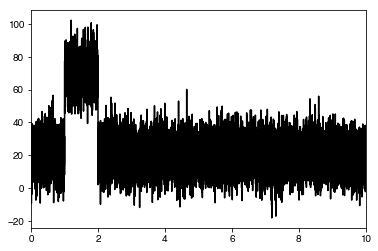

In [439]:
plt.plot(T, myInput[0],"k-")
plt.xlim([startT,totalT])
plt.show()

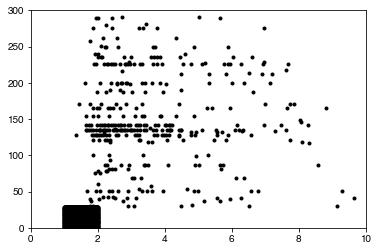

In [440]:
x_val = [x[0] for x in spikes]
y_val = [x[1] for x in spikes]
plt.plot(x_val, y_val,"k.")
plt.xlim([startT,totalT])
plt.ylim([0.,N])
plt.show()

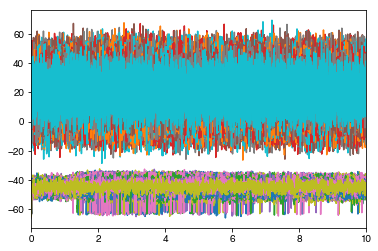

In [437]:
for i in range(Nstim,N):
    plt.plot(T, voltage[i]/mV,"-")
    plt.plot(T, currents[i]/mV,"-")
plt.xlim([startT,totalT])
plt.show()